In [1]:
import jax
import jax.numpy as jnp
from jax import grad, value_and_grad, jit
from jax.scipy.stats import norm, rankdata
from jax.scipy.special import digamma
from jax.scipy.linalg import cho_factor, cho_solve
from jax.example_libraries import optimizers
from jax.scipy.linalg import cholesky
from scipy.stats import differential_entropy
import matplotlib.pyplot as plt


In [2]:

class OlfactorySensing:
    def __init__(self, N=30, n=2, M=10, sigma_0=1e-2, sigma_c=2): 
        self.N = N
        self.n = n
        self.M = M
        self.sigma_0 = sigma_0
        self.sigma_c = sigma_c
        self.set_sigma()

    def draw_c(self, key): 
        c = jnp.zeros(self.N)
        # Select non-zero indices
        non_zero_indices = jax.random.choice(key, self.N, shape=(self.n,), replace=False)
        concentrations = jax.random.lognormal(key, sigma=self.sigma_c, shape=(self.n,))
        c = c.at[non_zero_indices].set(concentrations)
        return c
    
    def draw_cs(self, P, key):
        keys = jax.random.split(key, P)
        self.P = P
        self.vasicek_window = jax.lax.stop_gradient(jnp.round(jnp.sqrt(P) + 0.5)).astype(int)
        return jnp.array([self.draw_c(k) for k in keys]).T

    def set_sigma(self): 
        self.sigma = lambda x: x / (1 + x) 

    def set_random_W(self, key): 
        self.W = 1 / jnp.sqrt(self.N) * jax.random.normal(key, shape=(self.M, self.N))

    def compute_activity(self, c, key): 
        pre_activations = self.W @ c
        r = self.sigma(pre_activations) + self.sigma_0 * jax.random.normal(key, shape=pre_activations.shape) 
        return r

    def compute_entropy_of_r(self, key, P=100):
        # c = self.draw_cs(P, key)
        c = self.cs 
        self.r = self.compute_activity(c, key)
        entropy = self.compute_sum_of_marginal_entropies() - self.compute_information_of_r()
        return entropy

    def compute_sum_of_marginal_entropies(self):
        marginal_entropies = jnp.array([self._vasicek_entropy(self.r[m, :]) for m in range(self.M)])
        return jnp.sum(marginal_entropies)
    
    def compute_information_of_r(self): 
        M, P = self.r.shape
        G = norm.ppf((rankdata(self.r.T, axis=0) / (P + 1)), loc=0, scale=1)
        bias_correction = 0.5 * jnp.sum(digamma((P - jnp.arange(1, M + 1) + 1) / 2) - jnp.log(P / 2))
        cov_matrix = jnp.cov(G, rowvar=False)
        chol_decomp = cholesky(cov_matrix)
        log_det = jnp.sum(jnp.log(jnp.diag(chol_decomp)))
        I = -(log_det - bias_correction)
        return I

    def _pad_along_last_axis(self, X, m):
        """Pad the data for computing the rolling window difference."""
        # this is translated directly from scipy.stats source code 
        shape = jnp.array(X.shape)
        shape = shape.at[-1].set(m)
        Xl = jnp.broadcast_to(X[..., [0]], shape)  # [0] vs 0 to maintain shape
        Xr = jnp.broadcast_to(X[..., [-1]], shape)
        return jnp.concatenate((Xl, X, Xr), axis=-1)

    def _vasicek_entropy(self, X):
        """Compute the Vasicek estimator as described in Eq. 1.3. of the 1975 paper"""
        n = X.shape[-1]
        X = jnp.sort(X, axis=-1)
        X = self._pad_along_last_axis(X, self.vasicek_window)
        differences = X[..., 2 * self.vasicek_window:] - X[..., : -2 * self.vasicek_window]
        logs = jnp.log(n / (2 * self.vasicek_window) * differences)
        return jnp.mean(logs, axis=-1)

In [3]:
os = OlfactorySensing()
key = jax.random.PRNGKey(0)
cs = os.draw_cs(P=1000, key=key)
os.W = jax.random.normal(key, shape=(10, 30))
os.r = os.compute_activity(cs, key)
os.cs = cs 

In [5]:
# Maximization with respect to W
def objective(W, key, os):
    os.W = W**2 # parametrize so that $W > 0$ 
    return - os.compute_entropy_of_r(key)  # Negate for maximization

# Set up JAX optimizer
N, M = 100, 30
os = OlfactorySensing(N=N, n=2, M=M)
key = jax.random.PRNGKey(0)
os.cs = os.draw_cs(P=1000, key=key) 
W_init = 1 / jnp.sqrt(N * M) * jax.random.normal(key, shape=(M, N))
os.W = W_init 
opt_init, opt_update, get_params = optimizers.adam(1e-3)
opt_state = opt_init(W_init)

def step(i, opt_state, key):
    W = get_params(opt_state)
    loss, grads = value_and_grad(objective)(W, key, os)
    opt_state = opt_update(i, grads, opt_state)
    return opt_state, loss  # return negative loss as the maximized entropy

# Run optimization
# @ jit # this breaks things for now
n_steps = 500
ent_values = []
for i in range(n_steps):
    key, subkey = jax.random.split(key)
    opt_state, entropy_value = step(i, opt_state, subkey)
    ent_values.append(entropy_value)
    if i % 100 == 0:
        print(f"Step {i}, Estimated Entropy: {-entropy_value}")

W_opt = jnp.sqrt(get_params(opt_state).reshape((M, N))) 
print("Optimized W:", W_opt)


Step 0, Estimated Entropy: -89.46623229980469
Step 100, Estimated Entropy: -59.603126525878906
Step 200, Estimated Entropy: -43.64543151855469
Step 300, Estimated Entropy: -34.87730407714844
Step 400, Estimated Entropy: -29.550735473632812
Optimized W: [[           nan            nan            nan ...            nan
  5.61319649e-01 5.47655344e-01]
 [4.82642174e-01            nan 5.50254643e-01 ...            nan
  5.31972955e-06            nan]
 [5.42300940e-01            nan 5.78557611e-01 ... 5.31724274e-01
  4.89300699e-04 5.55023491e-01]
 ...
 [4.93364215e-01            nan            nan ... 5.24082839e-01
  5.70929050e-01 1.26567287e-02]
 [4.97975707e-01 5.93290269e-01            nan ...            nan
  5.57027400e-01            nan]
 [5.22136033e-01            nan            nan ... 1.24529315e-05
  5.62362790e-01 5.52340448e-01]]


It this doing anything? 

Text(0, 0.5, '-H(r)')

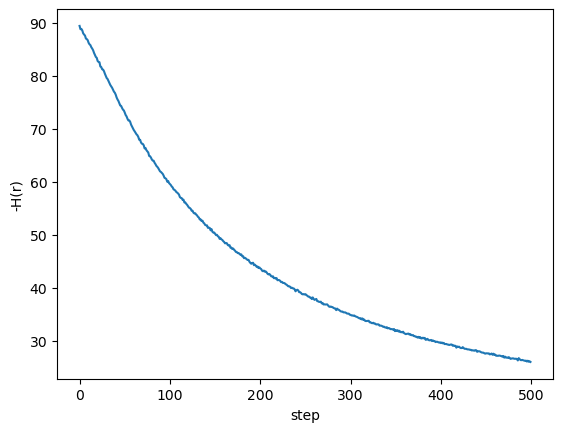

In [6]:
fig, ax = plt.subplots()
ax.plot(range(500), ent_values)
ax.set_xlabel('step') 
ax.set_ylabel('-H(r)')


Is the resulting matrix more sparse? No, not at all. 

In [34]:
W_init.shape

(30, 100)

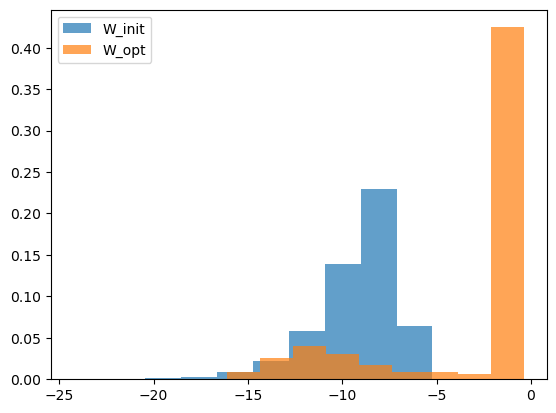

In [24]:
fig, ax = plt.subplots()
ax.hist(jnp.log(W_init.flatten()**2), label='W_init', alpha=0.7, density=True)
ax.hist(jnp.log(W_opt.flatten()), label='W_opt', alpha=0.7, density=True) 
ax.legend()

# Again check that mutual information increases with covariance

In [27]:
def compute_information(c, os, P, key): 
    cov = c * jnp.ones((30, 30))
    for i in range(cov.shape[0]): 
        cov = cov.at[i, i].set(1) 
    mean = jnp.zeros(cov.shape[0])  # Assuming a zero mean, adjust as needed
    os.r = jax.random.multivariate_normal(key, mean=mean, cov=cov, shape=(P,)).T
    I = os.compute_information_of_r()
    return I

I = compute_information(0, os, 1000, key)

In [31]:
Is = []

for c in jnp.linspace(0, .9, 10): 
    I = compute_information(c, os, 1000, key)
    Is.append(I) 

Text(0, 0.5, 'MI(r)')

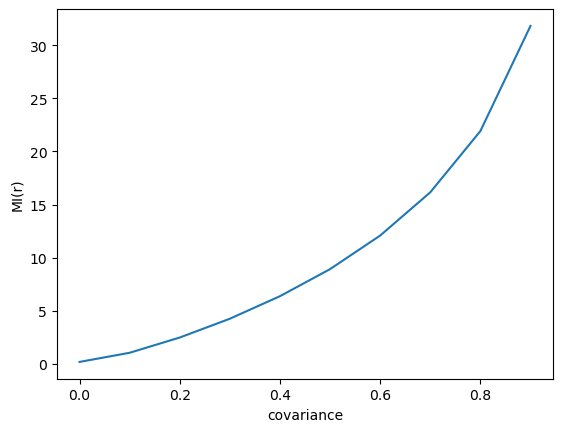

In [33]:
fig, ax = plt.subplots()
ax.plot(jnp.linspace(0, .9, 10), Is)
ax.set_xlabel('covariance') 
ax.set_ylabel('MI(r)')
